# معاملات الگوریتمی

در این تمرین، سعی می‌شود تا بر اساس نتایج پیش‌بینی تمرین شماره ۲ یک ربات ترید نوشته شود.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
import yfinance as yf       # https://pypi.org/project/yfinance/
import pytse_client as tse # https://pypi.org/project/pytse-client/

## دریافت داده

این بخش در تمرین شماره یک انجام گرفته و از همان کدها استفاده می‌شود.

دیتای پنج سهم از یاهوفاینانس دریافت می‌شود: اینتل، والمارت، اپل، پپسی و بانک آمریکا

In [64]:
tickers_nse = ['INTC', 'WMT', 'AAPL', 'PEP', 'BAC']
data_nse = yf.download(tickers_nse, group_by = 'ticker', start="2018-01-01", end="2022-11-04")

[*********************100%***********************]  5 of 5 completed


دیتای پنج سهم بازار بورس تهران دریافت می‌شود: وبصادر، شپنا، صندوق آگاس، فارس و کرمان

نام همه این سهام به معادل فینگلیش تغییر می‌کند تا در کدها راحت‌تر قابل استفاده باشد.

In [3]:
tickers_tse = ['وبصادر', 'شپنا', 'آگاس', 'فارس', 'کرمان']
prices_dict = tse.download(symbols=tickers_tse, adjust=True)
prices_dict_reform = {(outerKey, innerKey):
                             values for outerKey, innerDict 
                             in prices_dict.items() for innerKey, values 
                             in innerDict.iteritems()}
data_tse = pd.DataFrame(prices_dict_reform)
d = {'وبصادر': 'Websader', 'شپنا': 'Shepna', 'آگاس' : 'Agas', 'فارس' : 'Fars', 'کرمان' : 'Kerman'}
data_tse = data_tse.rename(columns=d, level=0)

## مدل‌سازی

این قسمت شبیه تمرین شماره ۲ است.

تابعی برای ساخت ماتریس لگ‌ها:

In [4]:
def lagmat(df, T=21) -> (np.array, np.array):
    X = []
    Y = []
    df['DiffLogP'] = df['LogP'].diff()
    series = df['DiffLogP'].to_numpy()[1:]
    for t in range(len(series) - T):
        x = series[t:t+T]
        X.append(x)
        y = series[t+T]
        Y.append(y)

    X = np.array(X).reshape(-1 ,T)
    Y = np.array(Y)

    return X, Y

تابعی برای دریافت داده آموزش و تست:

In [5]:
def get_train_test_set(df, test_count=20) -> (pd.DataFrame, pd.DataFrame):
    train_set = df[:-test_count]
    test_set = df[-test_count:]
    return train_set, test_set

تابع زیر در تمرین شماره دو نوشته شده است.

این تابع، سری قیمت‌ها و مدل موردنظر را به عنوان ورودی می‌گیرد و سه پیش‌بینی انجام می‌دهد: تک‌گام، چندگام استاتیک و چندگام دینامیک

مدل‌سازی بر روی لگاریتم قیمت‌ها صورت می‌گیرد.

In [6]:
def one_step_and_multistep_forecast(df, model, tag, test_count=20) -> pd.DataFrame:
    lags = 21   # number of lags to pass into lagmat function
    X, Y = lagmat(df, lags)

    # splitting the lagmat output to train and test
    x_train, y_train = X[:-test_count], Y[:-test_count]
    x_test, y_test = X[-test_count:], Y[-test_count:]
    # getting the train_set (different from x_train with 21 lags)
    train_set, _ = get_train_test_set(df)
    
    # fitting the model that was passed into the function with x_train and y_train
    model.fit(x_train, y_train)
    
    # storing the index of train and test dataset
    train_idx = df.index <= train_set.index[-1]
    test_idx = ~train_idx
    train_idx[:lags+1] = False

    df = pd.DataFrame(df)

    ### one step forecast
    # wee need to predict and undiffernce the result
    prev = df['LogP'].shift(1)
    df.loc[train_idx, f'{tag}_1step_train'] = \
        prev[train_idx] + model.predict(x_train)
    df.loc[test_idx, f'{tag}_1step_test'] = \
        prev[test_idx] + model.predict(x_test)

    ## multistep static forecast
    last_train = train_set.iloc[-1]['LogP']
    p = model.predict(x_test)
    df.loc[test_idx, f'{tag}_multistep_test_static'] = \
        last_train + np.cumsum(p)

    # multistep dynamic forecast
    multistep_predictions = []
    last_x = x_test[0]
    while len(multistep_predictions) < test_count:
        p = model.predict(last_x.reshape(1,-1))[0]

        multistep_predictions.append(p)

        last_x = np.roll(last_x, -1)
        last_x[-1] = p 
    
    last_train = train_set.iloc[-1]['LogP']
    df.loc[test_idx, f'{tag}_multistep_test'] = \
        last_train + np.cumsum(multistep_predictions)
    
    return df

تابعی برای رسم نمودار پیش‌بینی‌ها

In [7]:
def plot(df, tag):
    df[['LogP', f'{tag}_1step_train', f'{tag}_1step_test',
         f'{tag}_multistep_test', f'{tag}_multistep_test_static']][-100:].plot(figsize=(15,8))

یک پیش‌بینی برای اینتل انجام می‌دهیم و نمودار خروجی را می‌کشیم (مشابه تمرین پیشین):

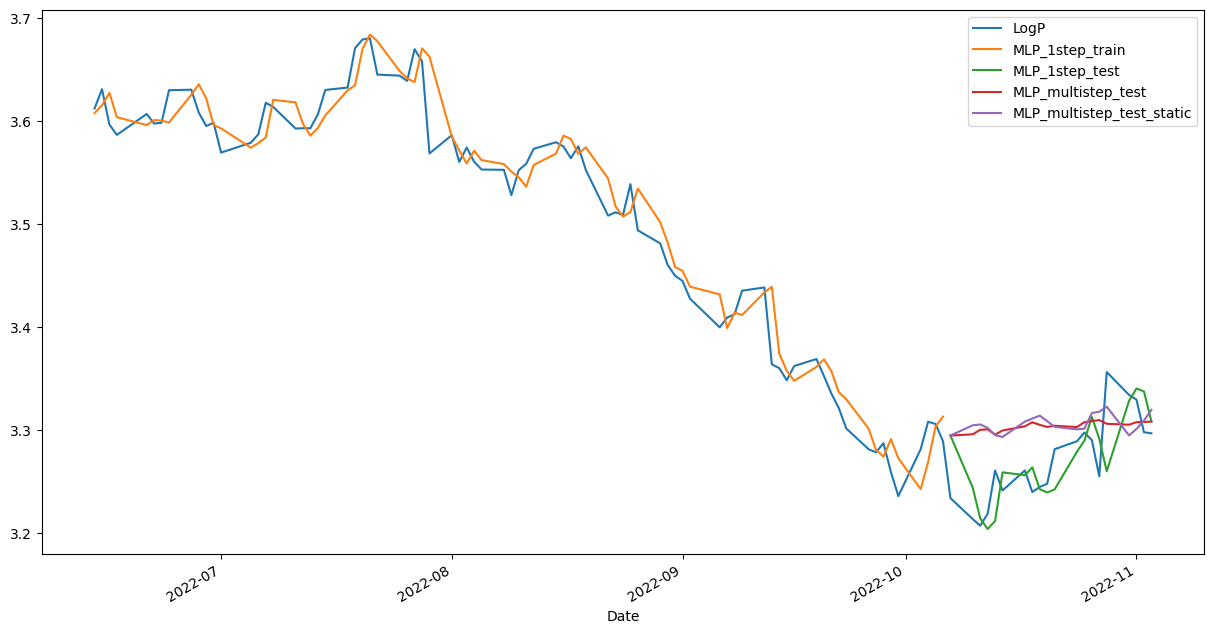

In [68]:
df_data = data_nse['INTC']
df_data = df_data[['Adj Close']]
df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
df_data['LogP'] = np.log(df_data['P'])

df_data = one_step_and_multistep_forecast(df_data, MLPRegressor(), "MLP")
plot(df_data, tag="MLP")

## معاملات الگوریتیم

تابعی برای معاملات الگوریتمی می‌نویسم.

در صورتی که پیش‌بینی بازده فردا، مثبت باشد آن‌گاه دستور خرید صادر می‌شود و در صورتی که منفی باشد، دستور فروش (برای بازار نیویورک و نه تهران) صادر می‌شود.

پس از هر روز، بازده مربوط به معامله آن روز محاسبه می‌شود و سری تجمعی بازده‌های این الگوریتم و سری تجمعی بازده‌های واقعی به دیتافریم ورودی اضافه می‌شود و در خروجی تابع قرار می‌گیرد.

In [99]:
def algo_trade(df, is_short_sell=True):
    df['is_going_up'] = df['LogP'] < df['MLP_1step_test'].shift(-1)
    df['ret'] = df['P'].pct_change().shift(-1)
    if is_short_sell:
        df['buy_sell'] = -1
    else:
        df['buy_sell'] = 0
    df.loc[df['is_going_up'], 'buy_sell'] = 1
    df['algo_ret'] = df['ret']*df['buy_sell']
    df['algo_ret_cumsum'] = -df.iloc[-20]['algo_ret'] + np.cumsum(df[-20:]['algo_ret'])
    df['actual_ret_cumsum'] = -df.iloc[-20]['ret'] + np.cumsum(df[-20:]['ret'])

    return df

برای پنج سهم بورس نیویورک، تابع بالا فراخوانی می‌شود و نمودار بازده تحقق‌یافته و بازده معاملات الگوریتمی رسم می‌شود.

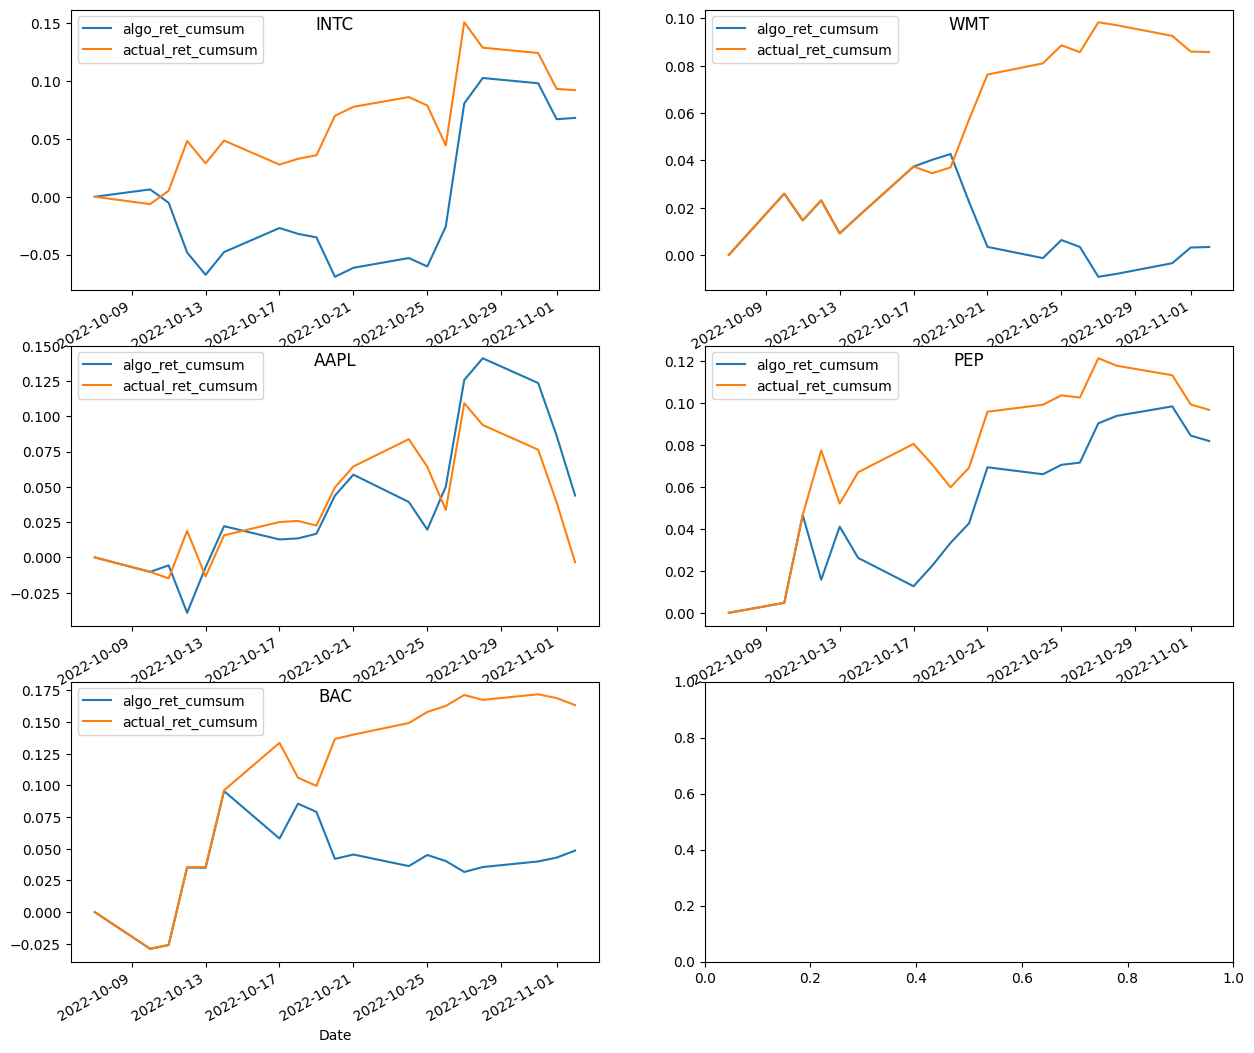

In [87]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 14))
for ax, ticker in zip(axes.flat, tickers_nse):

    df_data = data_nse[ticker]
    df_data = df_data[['Adj Close']]
    df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
    df_data['LogP'] = np.log(df_data['P'])

    df_data = one_step_and_multistep_forecast(df_data, MLPRegressor(), "MLP")

    x = algo_trade(df=df_data)[['algo_ret_cumsum', 'actual_ret_cumsum']].plot( ax=ax)
    x.set_title(ticker, x=0.5, y=0.90)
plt.show()

در مجموع به نظر می‌رسد مدل و الگوریتم معاملاتی، موفق عمل نکرده‌اند.

همان کار بالا را برای پنج سهم دریافت‌شده بازار بورس تهران انجام می‌دهیم.

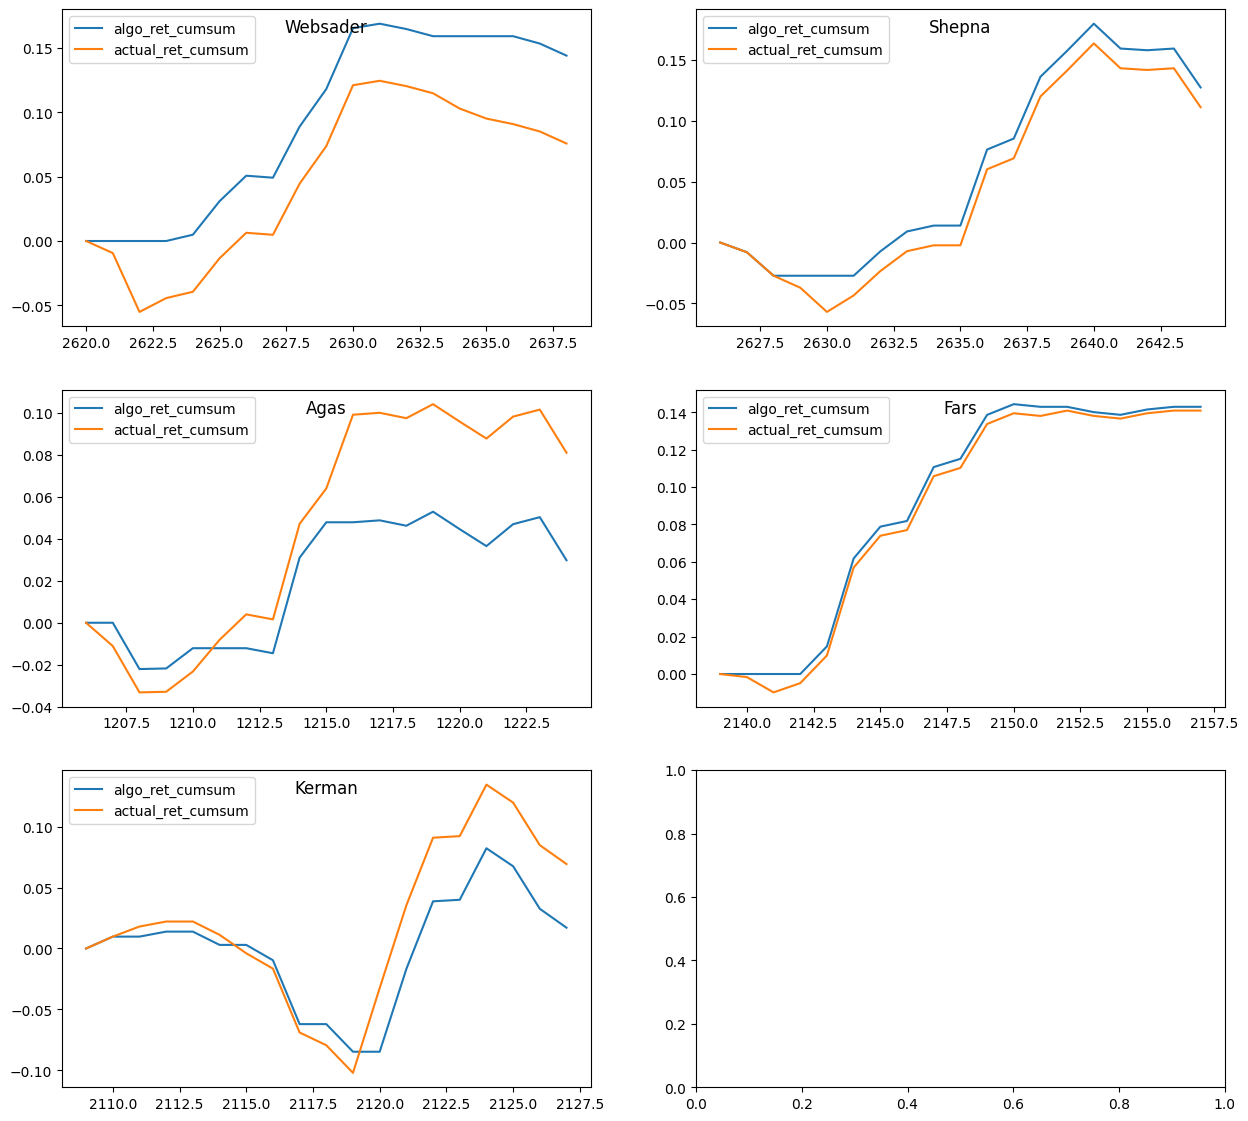

In [101]:
tickers = list(d.values())
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 14))
for ax, ticker in zip(axes.flat, tickers):

    df_data = data_tse[ticker]
    df_data = df_data.rename({'adjClose': 'Adj Close'}, axis=1)
    df_data = df_data[['Adj Close']].dropna()
    df_data = df_data.rename({'Adj Close': 'P'}, axis=1)
    df_data['LogP'] = np.log(df_data['P'])

    df_data = one_step_and_multistep_forecast(df_data, MLPRegressor(), "MLP")

    x = algo_trade(df=df_data, is_short_sell=False)[['algo_ret_cumsum', 'actual_ret_cumsum']].plot( ax=ax)
    x.set_title(ticker, x=0.5, y=0.90)
plt.show()

نتایج این مدل والگوریتم برای بازار بورس تهران، به نظر بهتر می‌رسد. هر چند که با چند بار ران کردن کد، نتایج متفاوت می‌شوند و نمی‌توان در حالت کلی به این الگوریتم و مدل اعتماد کرد.